# Project in Keras

Based on: https://github.com/rachhek/speech_recognition_using_lstm/blob/master/speech_recognition_using_lstm_experiment.ipynb


In [2]:
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional,Flatten
from keras.layers import SpatialDropout1D, SpatialDropout2D, SpatialDropout3D, Bidirectional
from keras.layers import Conv1D, BatchNormalization, Conv2D, MaxPooling2D, MaxPooling1D, Flatten, Dropout, Reshape
from python_speech_features import mfcc
from python_speech_features import logfbank
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder,normalize
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import scipy.io.wavfile as wav
import numpy as np
import keras
import csv
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import librosa
import soundfile as sf
import pickle

# Preprocessing with spectogram (can be run only once)

In [3]:
! cp /kaggle/input/tensorflow-speech-recognition-challenge/train.7z ./
! 7za x train.7z

In [4]:
def convert_background_noise(root_path='./train', input_folder='_background_noise_', output_folder='silence'):
    audio_path = os.path.join(root_path, 'audio')
    input_path = os.path.join(audio_path, input_folder)
    output_path = os.path.join(audio_path, output_folder)
    
    sample_rate = 16000
    sample_length = 1

    audio_files = [d for d in os.listdir(input_path)
                   if os.path.isfile(os.path.join(input_path, d)) and d.endswith('.wav')]
    samples = []

    for f in audio_files:
        path = os.path.join(input_path, f)
        s, _ = librosa.load(path, sr=sample_rate)
        samples.append(s)

    samples = np.hstack(samples)
    c = int(sample_rate * sample_length)
    r = len(samples) // c
    names = [f'recording_{i}.wav' for i in range(r-1)]

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for i in range(r - 1):
        y = samples[c*i:c*(i+1)]
        sf.write(os.path.join(output_path, names[i]), y, sample_rate)

    val_choice = np.random.choice(names, int(0.1*len(names)), replace=False).tolist()
    with open(os.path.join(root_path, 'validation_list.txt'), 'a') as f:
        for name in val_choice:
            p = os.path.join(output_folder, name)
            p = p.replace('./', '')
            f.write(p)
            f.write('\n')

    test_choice = np.random.choice([n for n in names if n not in val_choice], int(0.1*len(names)), replace=False).tolist()
    with open(os.path.join(root_path, 'testing_list.txt'), 'a') as f:
        for name in test_choice:
            p = os.path.join(output_folder, name)
            p = p.replace('./', '')
            f.write(p)
            f.write('\n')


In [5]:
convert_background_noise(root_path='./train', input_folder='_background_noise_', output_folder='silence')

In [6]:
def load_dataset(root_path_files, files_names_list_name, label_encoder=None):
    #Calculating x_test and y_test        
    test_labels = []
    test_data = []

    #test_labels.txt is a txt file with all labels for the speech samples that is required for the evaluation. We loop through it to calculate the MFCC value for each speech sample and then normalize it
    with open(os.path.join(root_path_files, files_names_list_name), newline='') as tsvfile:
        reader = csv.DictReader(tsvfile)
        reader = csv.reader(tsvfile, delimiter=' ')
        for row in reader:
            wav_file = os.path.join(root_path_files, "audio/", row[0])

            row.append(row[0].split("/")[0])
            (rate,sig) = wav.read(wav_file)

            # pad to 1s of length using pad_sequences
            sig = pad_sequences([sig], maxlen=16000, dtype='float', padding='post', truncating='post', value=0.0)

            #Getting the MFCC value from the .wav files.
            mfcc_feat = mfcc(sig,rate)
            
            scaler = MinMaxScaler(feature_range=(0,1))
            scaler = scaler.fit(mfcc_feat)

            #Normalizing the MFCC values.
            normalized = scaler.transform(mfcc_feat)
            test_data.append(normalized)
            test_labels.append(str(row[1]))
        
        if label_encoder is None:
            label_encoder_test = LabelEncoder().fit(test_labels)
        else:
            label_encoder_test = label_encoder
        vec_test = label_encoder_test.transform(test_labels)

        #One hot encoding the labels
        one_hot_labels_test = keras.utils.to_categorical(vec_test, num_classes=len(label_encoder_test.classes_))
        Y_test = one_hot_labels_test
        X_test = np.array(test_data,dtype=np.float32)
        return X_test, Y_test, label_encoder_test

In [7]:
def generate_train_txt(root_path_files, files_names_list_name):
    omit = []
    train = []
    for f in files_names_list_name:
        with open(os.path.join(root_path_files, f)) as fileobj:
            omit += [line.strip() for line in fileobj]
    for target in os.listdir(os.path.join(root_path_files, 'audio')):
        if not target.startswith('_'):
            for file in os.listdir(os.path.join(root_path_files, 'audio', target)):
                p = os.path.join(target, file)
                if p not in omit:
                    train.append(p)
    with open(os.path.join(root_path_files, 'training_list.txt'), 'wb') as file:
        for t in train:
            file.write(t.encode())
            file.write('\n'.encode())

In [8]:
! mkdir ./preprocessed

In [9]:
root_path_files = './train'
root_saved_files = './preprocessed'

generate_train_txt(root_path_files, ['validation_list.txt', 'testing_list.txt'])

train_files_names_list_name = 'training_list.txt'
X_train, Y_train, label_encoder = load_dataset(root_path_files=root_path_files, files_names_list_name=train_files_names_list_name)
np.save(os.path.join(root_saved_files, 'X_train'), X_train)
np.save(os.path.join(root_saved_files, 'Y_train'), Y_train)

valid_files_names_list_name = 'validation_list.txt'
X_valid, Y_valid, _ = load_dataset(root_path_files=root_path_files, files_names_list_name=valid_files_names_list_name, 
                                   label_encoder=label_encoder)
np.save(os.path.join(root_saved_files, 'X_valid'), X_valid)
np.save(os.path.join(root_saved_files, 'Y_valid'), Y_valid)

test_files_names_list_name = 'testing_list.txt'
X_test, Y_test, _ = load_dataset(root_path_files=root_path_files, files_names_list_name=test_files_names_list_name, 
                                 label_encoder=label_encoder)
np.save(os.path.join(root_saved_files, 'X_test'), X_test)
np.save(os.path.join(root_saved_files, 'Y_test'), Y_test)

In [10]:
#with open('encoder', 'wb') as f:
#    pickle.dump(label_encoder, f)

# Loading data

In [8]:
import numpy as np
import os
import pickle

In [7]:
# load the test data and labels
root_saved_files = './preprocessed'

X_train = np.load(os.path.join(root_saved_files,'X_train.npy'))
Y_train = np.load(os.path.join(root_saved_files, 'Y_train.npy'))

X_test = np.load(os.path.join(root_saved_files, 'X_test.npy'))
Y_test = np.load(os.path.join(root_saved_files, 'Y_test.npy'))

X_valid = np.load(os.path.join(root_saved_files, 'X_valid.npy'))
Y_valid = np.load(os.path.join(root_saved_files, 'Y_valid.npy'))

In [9]:
with open('encoder', 'rb') as f:
    encoder = pickle.load(f)
    CLASSES = encoder.classes_

# Experiments

In [14]:
n_classes = len(CLASSES)

In [15]:
def update_seed(new_random_seed):
    np.random.seed(new_random_seed)
    tf.keras.utils.set_random_seed(new_random_seed)

In [16]:
def train_model(model, train_data, val_data, test_data, lr, epochs, batch, labels=CLASSES, path='checkpoint'):
    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, mode = 'min')
    ]
    m = model()
    m.compile(optimizer=Adam(amsgrad=True, learning_rate=lr),loss='categorical_crossentropy',metrics=['accuracy'])
    history = m.fit(train_data[0], train_data[1],
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=batch,
                    validation_data=val_data,
                    verbose=1,
                    shuffle=True)

    datetime = time.strftime("%Y%m%d-%H%M%S")
    m.save(os.path.join(path, 'model_' + datetime))

    #plotting the loss
    history = m.history
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history["val_loss"])
    pyplot.title("train and validation loss")
    pyplot.ylabel("value")
    pyplot.xlabel("epoch")
    pyplot.legend(['train','validation'])
    plt.show()

    #plotting the loss
    pyplot.plot(history.history['accuracy'])
    pyplot.plot(history.history["val_accuracy"])
    pyplot.title("train and validation accuracy")
    pyplot.ylabel("accuracy value")
    pyplot.xlabel("epoch")
    pyplot.legend(['train','validation'])
    plt.show()

    y_prediction = m.predict(test_data[0])
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test_single_column=np.argmax(test_data[1], axis=1)
    result = confusion_matrix(y_test_single_column, y_prediction , normalize='pred')
    plt.figure(figsize=(20,20))
    labels = labels
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix on test data')
    plt.show()
    
    result = confusion_matrix(y_test_single_column, y_prediction)
    plt.figure(figsize=(20,20))
    labels = labels
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix on test data')
    plt.show()

    
    acc_train = accuracy_score(np.argmax(train_data[1], axis=1), np.argmax(m.predict(train_data[0]), axis = 1))
    print(f"Accuracy score on train dataset: {acc_train}")
    acc_val = accuracy_score(np.argmax(val_data[1], axis=1), np.argmax(m.predict(val_data[0]), axis = 1))
    print(f"Accuracy score on validation dataset: {acc_val}")
    acc_test = accuracy_score(y_test_single_column, y_prediction)
    print(f"Accuracy score on test dataset: {acc_test}")

    return [acc_train, acc_val, acc_test]

In [17]:
def repeat_train(model, train_data, val_data, test_data, lr, epochs, batch, seeds, labels=CLASSES, path='checkpoint'):
    accuracy = []
    for seed in seeds:
        print(f"Training with seed {seed}")
        p = os.path.join(path, str(seed))
        if not os.path.exists(path):
            os.mkdir(path)
        if not os.path.exists(p):
            os.mkdir(p)
        update_seed(seed)
        acc = train_model(model, train_data, val_data, test_data, lr, epochs, batch, labels, path=p)
        accuracy.append(acc)
    with open(os.path.join(path, 'accuracy'), 'wb') as f:
        pickle.dump(accuracy, f)

## Experiments running!

In [18]:
def model1():
    model = Sequential()
    model.add(LSTM(200,input_shape=(99,13),return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(Y_test.shape[1], activation='softmax'))
    return model

In [19]:
repeat_train(model1, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_lstm_one_layer')

In [20]:
def model2():
    model = Sequential()
    model.add(LSTM(200,input_shape=(99,13),return_sequences=True))
    model.add(LSTM(200,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [21]:
repeat_train(model2, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_lstm_two_layer')

In [22]:
def model3():
    model = Sequential()
    model.add(LSTM(200,input_shape=(99,13),return_sequences=True))
    model.add(LSTM(200,return_sequences=True))
    model.add(LSTM(200,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [23]:
repeat_train(model3, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_lstm_three_layer')

In [24]:
def model4():
    model = Sequential()
    model.add(Bidirectional(LSTM(200, input_shape=(99,13), return_sequences=True)))
    model.add(Bidirectional(LSTM(200, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [25]:
repeat_train(model4, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_lstm_bidirectional')

In [26]:
def model5():
    model = Sequential()
    model.add(LSTM(20, input_shape=(99,13),return_sequences=True))
    model.add(LSTM(20, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [27]:
repeat_train(model5, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_lstm_hidden_20')

In [28]:
def model6():
    model = Sequential()
    model.add(LSTM(100,input_shape=(99,13),return_sequences=True))
    model.add(LSTM(100,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [29]:
repeat_train(model6, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_lstm_hidden_100')

In [30]:
def model7():
    model = Sequential()
    model.add(LSTM(300,input_shape=(99,13),return_sequences=True))
    model.add(LSTM(300,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [31]:
repeat_train(model7, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_lstm_hidden_300')

In [32]:
def model8():
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=10, strides=4, input_shape=(99,13)))
    model.add(BatchNormalization())
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [33]:
repeat_train(model8, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_conv1d_lstm')

In [34]:
def model9():
    model = Sequential()
    model.add(Reshape((99, 13, 1), input_shape=(99, 13)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [35]:
repeat_train(model9, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_conv2d')

In [36]:
def model10():
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [37]:
repeat_train(model10, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_conv1d')

## Other approaches

1. The main goal of the Kaggle competition is to make predictions on 12 target classes (10 commands + silence + Unknown). In above experiments, we considered all 31 classes, so we have dealt with a bigger task. For the final predictions, we would aggregate predictions for all not considered classes into target "Unknown" label. Let's now consider using the "Unknown" label for not considered classes.

In [59]:
def transform_y(y, encoder, new_classes, new_encoder=None):
    def translate(x, new=new_classes):
        if x in new:
            return x
        else:
            return 'unknown'
    
    y_new = encoder.inverse_transform(np.argmax(y, axis=1))
    y_new = np.array(list(map(translate, y_new)))
    
    if new_encoder is None:
        new_encoder = LabelEncoder().fit(y_new)
        
    y_new = new_encoder.transform(y_new)
    return keras.utils.to_categorical(y_new, num_classes=len(np.unique(y_new))), new_encoder

In [60]:
new_classes = 'unknown, silence, yes, no, up, down, left, right, on, off, stop, go'.split(', ')

In [61]:
Y_train_with_unknown, new_encoder1 = transform_y(Y_train, encoder, new_classes)
Y_valid_with_unknown, _ = transform_y(Y_valid, encoder, new_classes, new_encoder1)
Y_test_with_unknown, _ = transform_y(Y_test, encoder, new_classes, new_encoder1)

In [62]:
def model11():
    model = Sequential()
    model.add(LSTM(200,input_shape=(99,13),return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(Y_train_with_unknown.shape[1], activation='softmax'))
    return model

In [ ]:
repeat_train(model11, (X_train, Y_train_with_unknown), (X_valid, Y_valid_with_unknown), (X_test, Y_test_with_unknown), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], labels=new_encoder1.classes_, path='checkpoint_lstm_with_unknown')

2. The model trained on all classes had quite a problem with silence class. This is why we wanted to train a model to recognize silence from all other possible classes.

In [63]:
Y_train_silence, new_encoder2 = transform_y(Y_train, encoder, ['silence'])
Y_valid_silence, _ = transform_y(Y_valid, encoder, ['silence'], new_encoder2)
Y_test_silence, _ = transform_y(Y_test, encoder, ['silence'], new_encoder2)

In [ ]:
def model12():
    model = Sequential()
    model.add(LSTM(200,input_shape=(99,13),return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(Y_train_silence.shape[1], activation='softmax'))
    return model

In [ ]:
repeat_train(model12, (X_train, Y_train_silence), (X_valid, Y_valid_silence), (X_test, Y_test_silence), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], labels=new_encoder2.classes_, path='checkpoint_lstm_only_silence')

3. As both approaches above cause class imbalance, we will add weights. We hope it will diminish the effects of the accuracy paradox. This experiment requires changes in the training function

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
def train_model2(model, train_data, val_data, test_data, lr, epochs, batch, labels, path='checkpoint'):
    # class weights
    targets = np.argmax(train_data[1], axis=1).tolist()
    classes_unique = sorted(np.unique(targets).tolist())
    class_weights = compute_class_weight('balanced', classes=classes_unique, y=targets)
    class_weights = {classes_unique[i]: class_weights[i] for i in range(len(class_weights))}

    
    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, mode = 'min')
    ]
    m = model()
    m.compile(optimizer=Adam(amsgrad=True, learning_rate=lr),loss='categorical_crossentropy',metrics=['accuracy'])
    history = m.fit(train_data[0], train_data[1],
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=batch,
                    validation_data=val_data,
                    verbose=1,
                    shuffle=True,
                    class_weight=class_weights)

    datetime = time.strftime("%Y%m%d-%H%M%S")
    m.save(os.path.join(path, 'model_' + datetime))

    #plotting the loss
    history = m.history
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history["val_loss"])
    pyplot.title("train and validation loss")
    pyplot.ylabel("value")
    pyplot.xlabel("epoch")
    pyplot.legend(['train','validation'])
    plt.show()

    #plotting the loss
    pyplot.plot(history.history['accuracy'])
    pyplot.plot(history.history["val_accuracy"])
    pyplot.title("train and validation accuracy")
    pyplot.ylabel("accuracy value")
    pyplot.xlabel("epoch")
    pyplot.legend(['train','validation'])
    plt.show()

    y_prediction = m.predict(test_data[0])
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test_single_column=np.argmax(test_data[1], axis=1)
    result = confusion_matrix(y_test_single_column, y_prediction , normalize='pred')
    plt.figure(figsize=(20,20))
    labels = labels
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix on test data')
    plt.show()
    
    result = confusion_matrix(y_test_single_column, y_prediction)
    plt.figure(figsize=(20,20))
    labels = labels
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix on test data')
    plt.show()

    
    acc_train = accuracy_score(np.argmax(train_data[1], axis=1), np.argmax(m.predict(train_data[0]), axis = 1))
    print(f"Accuracy score on train dataset: {acc_train}")
    acc_val = accuracy_score(np.argmax(val_data[1], axis=1), np.argmax(m.predict(val_data[0]), axis = 1))
    print(f"Accuracy score on validation dataset: {acc_val}")
    acc_test = accuracy_score(y_test_single_column, y_prediction)
    print(f"Accuracy score on test dataset: {acc_test}")

    return [acc_train, acc_val, acc_test]

In [ ]:
def repeat_train2(model, train_data, val_data, test_data, lr, epochs, batch, seeds, labels, path='checkpoint'):
    accuracy = []
    for seed in seeds:
        print(f"Training with seed {seed}")
        p = os.path.join(path, str(seed))
        if not os.path.exists(path):
            os.mkdir(path)
        if not os.path.exists(p):
            os.mkdir(p)
        update_seed(seed)
        acc = train_model2(model, train_data, val_data, test_data, lr, epochs, batch, labels, path=p)
        accuracy.append(acc)
    with open(os.path.join(path, 'accuracy'), 'wb') as f:
        pickle.dump(accuracy, f)

3a. Repeat for the first approach

In [ ]:
repeat_train2(model11, (X_train, Y_train_with_unknown), (X_valid, Y_valid_with_unknown), (X_test, Y_test_with_unknown), lr=0.001, epochs=100, batch=32,
              seeds=[0, 10, 20, 30, 40], labels=new_classes, path='checkpoint_lstm_with_unknown_weighted')

3b. Repeat for the second approach

In [ ]:
repeat_train2(model12, (X_train, Y_train_silence), (X_valid, Y_valid_silence), (X_test, Y_test_silence), lr=0.001, epochs=100, batch=32,
              seeds=[0, 10, 20, 30, 40], labels=['unknown', 'silence'], path='checkpoint_lstm_only_silence')

## Confusion matrices with removed diagonal for the most interesting models

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def plot_conf_matrix_no_diagonal(path):
    model = keras.models.load_model(path)
    y_prediction = model.predict(X_test)
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test_single_column=np.argmax(Y_test, axis=1)
    
    result = confusion_matrix(y_test_single_column, y_prediction)
    np.fill_diagonal(result, 0)
    plt.figure(figsize=(20,20))
    labels = CLASSES
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix without diagonal on test data')
    plt.show()

In [ ]:
plot_conf_matrix_no_diagonal('checkpoint_lstm_three_layers/0/model_20230423-101725')

In [ ]:
plot_conf_matrix_no_diagonal('checkpoint_conv1d/10/model_20230423-193025')

In [ ]:
plot_conf_matrix_no_diagonal('checkpoint_conv2d/10/model_20230423-190231')

## Boxplots summarising accuracy scores 

In [1]:
# results taken from the calculations above

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
results_df = {
    'model': ['one layer LSTM (200)' for _ in range(5)] +
             ['two layer LSTM (200)' for _ in range(5)] +
             ['three layer LSTM (200)' for _ in range(5)] +
             ['bidirectional two layer LSTM (200)' for _ in range(5)] +
             ['two layer LSTM (20)' for _ in range(5)] +
             ['two layer LSTM (100)' for _ in range(5)] +
             ['two layer LSTM (300)' for _ in range(5)] +
             ['convolution 1D + two layer LSTM (128)' for _ in range(5)] +
             ['convolution 2D' for _ in range(5)] +
             ['convolution 1D' for _ in range(5)],
    'accuracy': [0.9047, 0.9132, 0.9090, 0.9073, 0.9003] +
                [0.9150, 0.9166, 0.9187, 0.9112, 0.9196] +
                [0.9217, 0.9207, 0.9172, 0.9203, 0.9162] +
                [0.9150, 0.9179, 0.9252, 0.9210, 0.9172] +
                [0.8462, 0.8459, 0.8322, 0.8468, 0.8347] +
                [0.9047, 0.9051, 0.9135, 0.9100, 0.9035] +
                [0.9090, 0.9176, 0.9205, 0.9172, 0.9207] +
                [0.8977, 0.9010, 0.9020, 0.8983, 0.8990] +
                [0.8066, 0.8052, 0.7849, 0.7967, 0.7880] +
                [0.8489, 0.8433, 0.8452, 0.8408, 0.8434]
}

In [3]:
results_df = pd.DataFrame(results_df)

In [4]:
sns.set_style('whitegrid')

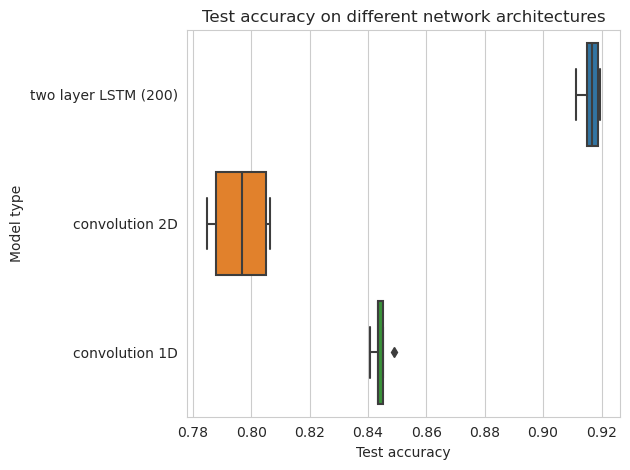

In [5]:
sns.boxplot(y='model', x='accuracy', data=results_df[results_df.model.isin([
    'convolution 1D', 'convolution 2D', 'two layer LSTM (200)'
])])
plt.xlabel('Test accuracy')
plt.ylabel('Model type')
plt.title('Test accuracy on different network architectures')

plt.tight_layout()
plt.show()

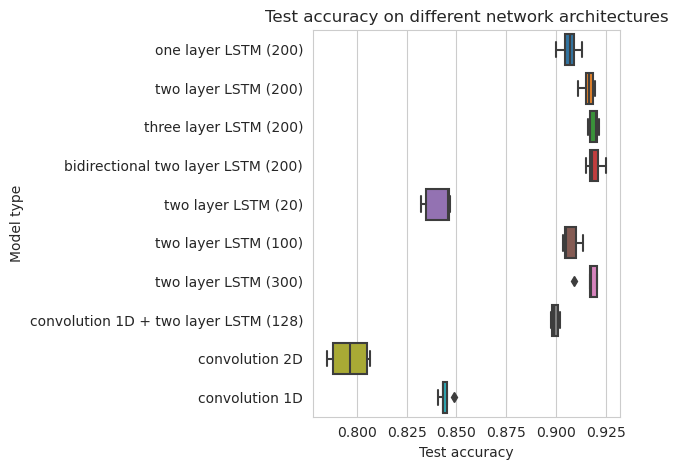

In [7]:
sns.boxplot(y='model', x='accuracy', data=results_df)
plt.xlabel('Test accuracy')
plt.ylabel('Model type')
plt.title('Test accuracy on different network architectures')

plt.tight_layout()
plt.show()

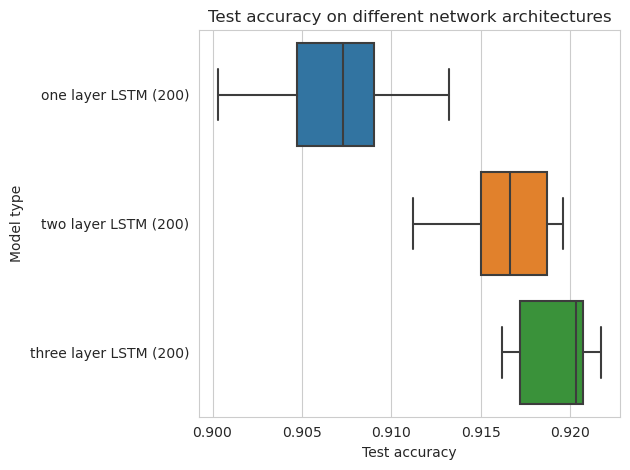

In [8]:
sns.boxplot(y='model', x='accuracy', data=results_df[results_df.model.isin([
    'one layer LSTM (200)', 'two layer LSTM (200)', 'three layer LSTM (200)'
])])
plt.xlabel('Test accuracy')
plt.ylabel('Model type')
plt.title('Test accuracy on different network architectures')

plt.tight_layout()
plt.show()

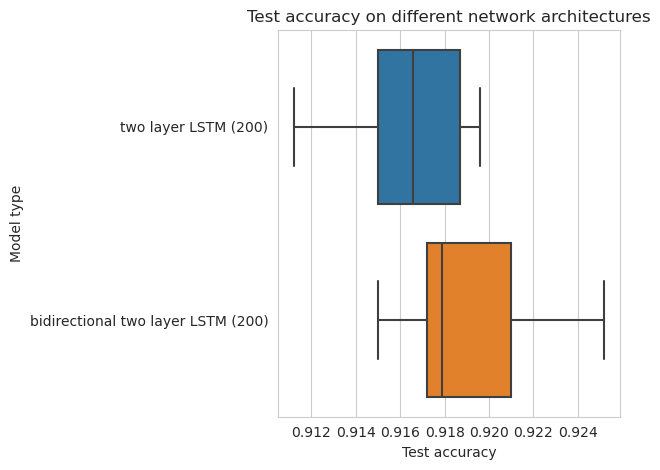

In [9]:
sns.boxplot(y='model', x='accuracy', data=results_df[results_df.model.isin([
    'two layer LSTM (200)', 'bidirectional two layer LSTM (200)'
])])
plt.xlabel('Test accuracy')
plt.ylabel('Model type')
plt.title('Test accuracy on different network architectures')

plt.tight_layout()
plt.show()

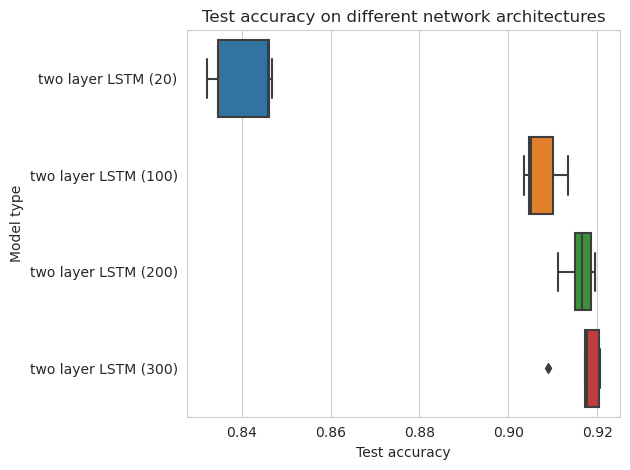

In [19]:
ranks = {'two layer LSTM (20)':0, 'two layer LSTM (100)':1, 'two layer LSTM (200)':2, 'two layer LSTM (300)':3}  
d = results_df[results_df.model.isin([
    'two layer LSTM (20)', 'two layer LSTM (100)', 'two layer LSTM (200)', 'two layer LSTM (300)'
])].copy()
d['rank'] = d.model.map(ranks)
d = d.sort_values('rank')
sns.boxplot(y='model', x='accuracy', data=d)
plt.xlabel('Test accuracy')
plt.ylabel('Model type')
plt.title('Test accuracy on different network architectures')

plt.tight_layout()
plt.show()

## Heatmaps with Welsh's statistical test results

In [22]:
from scipy.stats import ttest_ind
from functools import partial
import numpy as np

In [24]:
welsh_test = partial(ttest_ind, equal_var=False)

def extract_results_for_architecture(arch):
    return results_df[results_df.model == arch]['accuracy'].tolist()

architectures = np.unique(results_df.model).tolist()

In [25]:
p_values = {}

for a in architectures:
    p_values[a] = {}

In [26]:
for arch1 in architectures:
    x1 = extract_results_for_architecture(arch1)
    for arch2 in architectures:
        x2 = extract_results_for_architecture(arch2)
        _, p = welsh_test(x1, x2)

        p_values[arch1][arch2] = p
        p_values[arch2][arch1] = p

In [28]:
p_values = pd.DataFrame.from_dict(p_values)

In [38]:
order = ['two layer LSTM (20)', 'two layer LSTM (100)', 'two layer LSTM (200)', 'two layer LSTM (300)',
          'one layer LSTM (200)', 'three layer LSTM (200)', 'bidirectional two layer LSTM (200)',
          'convolution 1D', 'convolution 1D + two layer LSTM (128)', 'convolution 2D'
       ]

p_values = p_values.loc[order, order]

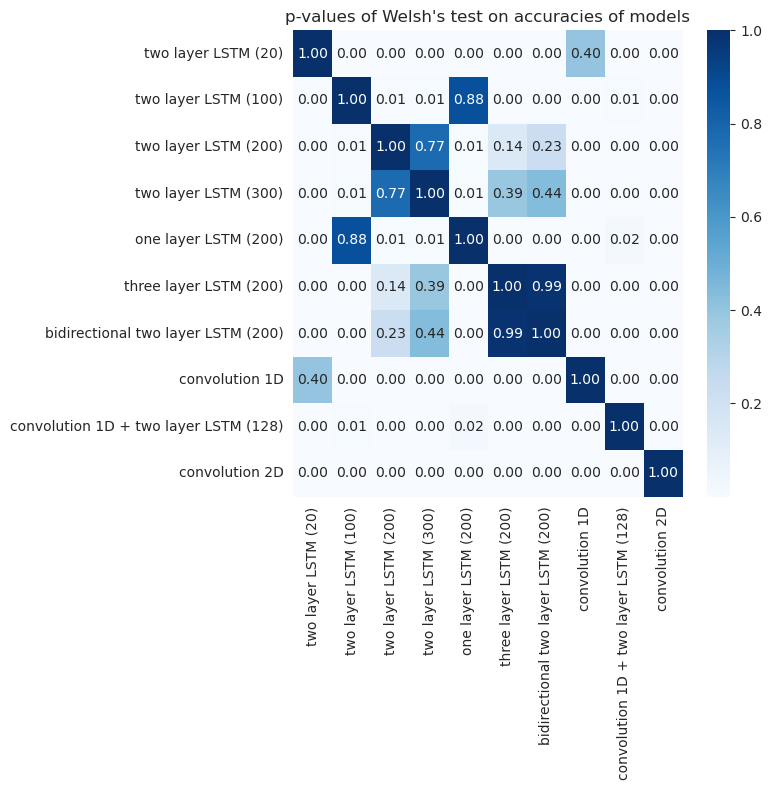

In [40]:
plt.subplots(figsize=(8, 8))
sns.heatmap(p_values, annot=True, fmt=".2f", cmap='Blues')
plt.title("p-values of Welsh's test on accuracies of models")

plt.tight_layout()
plt.show()